# Projet de Machine learning
Mélissa Ouada et Maxime Zielinger

## - 1er tour -

## Introduction

* Ce projet a pour but de prédire les résultats par commune des élections présidentielles françaises de 2022 au premier tour. Nous utiliserons des techniques de machine learning soit sous forme de régression soit comme classification pour réaliser nos prédictions.

### Dataset Principal
* Le fichier `resultats-par-niveau-subcom-t1-france-entiere.xlsx` contient les résultats du premier tour des élections présidentielles de 2022 par commune. [Source du dataset](https://www.data.gouv.fr/fr/datasets/election-presidentielle-des-10-et-24-avril-2022-resultats-du-1er-tour/).

### Données Supplémentaires
* Des données supplémentaires telles que les données géographiques et sociologiques des communes seront utilisées pour enrichir nos analyses. Ces données peuvent être trouvées sur [www.data.gouv.fr](https://www.data.gouv.fr/fr/datasets/revenus-des-francais-a-la-commune/).

* Il convient de noter que nous avons utilisé l'étude des résultats du tour 2 (projet_t2.ipynb) comme un ensemble d'entraînement (Apéritif) pour notre étude des résultats du tour 1.

## Objectifs
1. Analyser les données pour comprendre les tendances des votes.
2. Prédire le pourcentage de votes pour les principaux candidats.
3. Identifier les facteurs qui influencent les résultats des élections.

# Partie 1 : traitement et nettoyage des données

In [2]:
# Importation des librairies nécessaires
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import sklearn.linear_model as lm
import statsmodels 
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import classification_report
import seaborn as sns

C:\Users\maxim\AppData\Local\Temp\ipykernel_29504\1152117513.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Chargement et affichage du Dataset principal

Nous commençons par charger le dataset principal contenant les résultats du premier tour des élections. 

In [3]:
# Chargement du dataset
chemin_dataset = '../data/resultats-par-niveau-subcom-t1-france-entiere.xlsx'
data = pd.read_excel(chemin_dataset)

#Affichage du dataset
print(data.head())
print("\n")

  Code du département Libellé du département  Code de la commune  \
0                  01                    Ain                   1   
1                  01                    Ain                   2   
2                  01                    Ain                   4   
3                  01                    Ain                   5   
4                  01                    Ain                   6   

     Libellé de la commune Etat saisie  Inscrits  Abstentions  % Abs/Ins  \
0  L'Abergement-Clémenciat     Complet       645          108      16.74   
1    L'Abergement-de-Varey     Complet       213           38      17.84   
2        Ambérieu-en-Bugey     Complet      8765         2078      23.71   
3      Ambérieux-en-Dombes     Complet      1282          234      18.25   
4                  Ambléon     Complet       103           23      22.33   

   Votants  % Vot/Ins  ...  Unnamed: 93  Unnamed: 94  Unnamed: 95  \
0      537      83.26  ...            3         0.47         0.58

### Chargement et Affichage du Dataset Supplémentaire

Dans cette section, nous chargeons un dataset supplémentaire qui contient des informations sur le niveau de vie par commune en 2013. Ce dataset, intitulé `Niveau_de_vie_2013_a_la_commune-Global_Map_Solution.xlsx`, sera utilisé pour enrichir notre analyse en ajoutant une dimension socio-économique aux résultats électoraux.

Ce dataset supplémentaire peut fournir des informations sur la corrélation entre le niveau de vie et les tendances de vote dans différentes communes.

In [4]:
# Chargement du dataset suplementaire
chemin_datasup = '../data/Niveau_de_vie_2013_a_la_commune-Global_Map_Solution.xlsx'
supData = pd.read_excel(chemin_datasup)

# Affichage du dataset suplementaire
print(supData.head())
print("\n") 

  Code Commune              Nom Commune  Niveau de vie Commune  \
0        01001  L'Abergement-Clémenciat           22130.000000   
1        01002    L'Abergement-de-Varey           23213.000000   
2        01004        Ambérieu-en-Bugey           19554.000000   
3        01005      Ambérieux-en-Dombes           22387.619048   
4        01006                  Ambléon           21871.666667   

   Niveau de vie Département  
0               22343.574665  
1               22343.574665  
2               22343.574665  
3               22343.574665  
4               22343.574665  




In [5]:
#Affichage des informations sur les datasets

print("Data Informations")
print(data.shape)  # Taille du dataset
print(data.columns)  # Noms des colonnes
print(data.dtypes)  # Types de données pour chaque colonne

print("supData Informations")
print(supData.shape)
print(supData.columns)
print(supData.dtypes)

Data Informations
(35245, 103)
Index(['Code du département', 'Libellé du département', 'Code de la commune',
       'Libellé de la commune', 'Etat saisie', 'Inscrits', 'Abstentions',
       '% Abs/Ins', 'Votants', '% Vot/Ins',
       ...
       'Unnamed: 93', 'Unnamed: 94', 'Unnamed: 95', 'Unnamed: 96',
       'Unnamed: 97', 'Unnamed: 98', 'Unnamed: 99', 'Unnamed: 100',
       'Unnamed: 101', 'Unnamed: 102'],
      dtype='object', length=103)
Code du département        object
Libellé du département     object
Code de la commune          int64
Libellé de la commune      object
Etat saisie                object
                           ...   
Unnamed: 98                object
Unnamed: 99                object
Unnamed: 100                int64
Unnamed: 101              float64
Unnamed: 102              float64
Length: 103, dtype: object
supData Informations
(36572, 4)
Index(['Code Commune', 'Nom Commune', 'Niveau de vie Commune',
       'Niveau de vie Département'],
      dtype='object'

### Définition de la Fonction de Renommage des Colonnes

Pour faciliter l'analyse des données et améliorer la lisibilité de notre DataFrame, nous avons besoin de renommer les colonnes avec des noms plus descriptifs. La fonction `renommer_colonnes` est conçue pour cela. Elle prend en entrée le DataFrame, l'index de la première colonne à renommer, et un nombre qui sera ajoutée à la fin de chaque nouveau nom de colonne pour les distinguer.

In [6]:
# Définition de la fonction 'renommer_colonnes' pour renommer plusieurs colonnes d'un DataFrame
def renommer_colonnes(data, index_colonne, nombre):
    # Liste des préfixes des noms de colonnes à utiliser pour les nouvelles colonnes
    prefixes = ['N°Panneau', 'Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp']
    
    # Boucle sur chaque préfixe pour créer un nouveau nom de colonne et renommer la colonne correspondante
    for i, prefixe in enumerate(prefixes):
        # Formation du nouveau nom de colonne en ajoutant la lettre spécifiée à la fin du préfixe
        nouvelle_colonne = f'{prefixe}_{nombre}'
        
        # Renommage de la colonne dans le DataFrame. 
        # `f'Unnamed: {index_colonne + i}'` est l'ancien nom de la colonne.
        # `nouvelle_colonne` est le nouveau nom de la colonne.
        # `inplace=True` fait que la modification est faite directement sur le DataFrame original sans créer une copie.
        data.rename(columns={f'Unnamed: {index_colonne + i}': nouvelle_colonne}, inplace=True)
    
    # Retour du DataFrame avec les colonnes renommées
    return data

### Renommage des Colonnes pour Clarifier les Données

Pour une meilleure organisation et compréhension des données, nous renommons certaines colonnes clés en ajoutant un suffixe qui indique le panneau pour chaque condidat.

In [7]:
# Renommage de colonnes spécifiques en ajoutant le suffixe '_0' aux noms originaux.
data.rename(columns={'N°Panneau':'N°Panneau_0'}, inplace=True)  # Renommer 'N°Panneau' en 'N°Panneau_0'
data.rename(columns={'Sexe':'Sexe_0'}, inplace=True)            # Renommer 'Sexe' en 'Sexe_0'
data.rename(columns={'Nom':'Nom_0'}, inplace=True)              # Renommer 'Nom' en 'Nom_0'
data.rename(columns={'Prénom':'Prénom_0'}, inplace=True)        # Renommer 'Prénom' en 'Prénom_0'
data.rename(columns={'Voix':'Voix_0'}, inplace=True)            # Renommer 'Voix' en 'Voix_0'
data.rename(columns={'% Voix/Ins':'% Voix/Ins_0'}, inplace=True) # Renommer '% Voix/Ins' en '% Voix/Ins_0'
data.rename(columns={'% Voix/Exp':'% Voix/Exp_0'}, inplace=True) # Renommer '% Voix/Exp' en '% Voix/Exp_0'

# Une boucle pour renommer des groupes de colonnes en utilisant la fonction personnalisée 'renommer_colonnes'.
# La boucle itère sur une série d'indices de 26 à 101, avec un pas de 7 à chaque fois.
for i in range(26, 102, 7):
    # Appel de la fonction 'renommer_colonnes' pour renommer les colonnes aux positions de i à i+6 (inclus).
    # Le nommage inclut un suffixe qui augmente avec chaque itération de la boucle, commençant à partir de 1.
    # Ce suffixe est calculé en fonction de la position de 'i' dans la série, normalisé pour commencer à 0.    
    data = renommer_colonnes(data, i, str((i-26)//7 + 1))

In [8]:
#Affichage des informations sur le dataset après renommage des colonnes
print(data.shape)
print(data.columns)
print(data.dtypes)

(35245, 103)
Index(['Code du département', 'Libellé du département', 'Code de la commune',
       'Libellé de la commune', 'Etat saisie', 'Inscrits', 'Abstentions',
       '% Abs/Ins', 'Votants', '% Vot/Ins',
       ...
       'Voix_10', '% Voix/Ins_10', '% Voix/Exp_10', 'N°Panneau_11', 'Sexe_11',
       'Nom_11', 'Prénom_11', 'Voix_11', '% Voix/Ins_11', '% Voix/Exp_11'],
      dtype='object', length=103)
Code du département        object
Libellé du département     object
Code de la commune          int64
Libellé de la commune      object
Etat saisie                object
                           ...   
Nom_11                     object
Prénom_11                  object
Voix_11                     int64
% Voix/Ins_11             float64
% Voix/Exp_11             float64
Length: 103, dtype: object


### Conversion des Codes de Département

Pour standardiser les données et faciliter les analyses ultérieures, nous convertissons les codes de départements spécifiques en utilisant des valeurs numériques. Cette opération est réalisée par la fonction `convertDepartment`, qui utilise un dictionnaire pour le mappage des valeurs.

In [9]:
# Définition de la fonction 'convertDepartment' qui convertit les codes de départements spécifiques
# en utilisant un dictionnaire de mappage pour les remplacer par des valeurs numériques.
def convertDepartment(data):
    # Dictionnaire définissant les correspondances entre les codes de département originaux.
    code_dict = {
        '2A': 96, '2B': 97, 'ZP': 98, 'ZS': 99, 'ZW': 100, 
        'ZX': 101, 'ZZ': 102, 'ZN': 103, 'ZD': 104, 'ZM': 105, 
        'ZC': 106, 'ZB': 107, 'ZA': 108
    }

    # Boucle sur chaque code de département dans la colonne 'Code du département' du DataFrame
    for i in data['Code du département']:
        # Si le code de département actuel est trouvé dans le dictionnaire de mappage,
        # il est remplacé dans toute la colonne par le nouveau code numérique correspondant.
        if i in code_dict:
            data['Code du département'] = data['Code du département'].replace(i, code_dict[i])
    
    # Retourne le DataFrame avec les codes de département mis à jour.
    return data


### Traitement et Enrichissement des Données

Pour améliorer la qualité de nos analyses et permettre des comparaisons plus précises avec d'autres datasets, nous procédons à une séparation du code de la commune en deux parties distinctes : le code du département et le code spécifique de la commune. Cela nous aide également à enrichir notre dataset final avec des données supplémentaires de manière structurée.

#### Etapes de Traitement

1. **Extraction du Code du Département :** Nous extrayons les deux premiers caractères du 'Code Commune' pour créer une nouvelle colonne qui identifiera clairement le département.

2. **Formation du Code de la Commune :** Le reste des caractères, après les deux premiers, est utilisé pour former un code unique de la commune dans une nouvelle colonne.

3. **Suppression des Colonnes Redondantes :** Pour éviter les redondances et optimiser la structure de notre dataset, nous supprimons les colonnes originales qui sont désormais inutiles grâce à notre nouvelle segmentation.

4. **Conversion des Types de Données :** Nous convertissons le 'Code de la commune' en entier pour assurer une cohérence dans les types de données.

5. **Fusion des DataFrames :** Nous fusionnons le DataFrame principal avec les données supplémentaires basées sur les codes de département et de commune. Cette étape est réalisée en utilisant une jointure interne pour exclure toute ligne sans correspondance exacte dans les deux sets de données.

6. **Nettoyage Final :** Toutes les lignes contenant des valeurs manquantes sont éliminées pour maintenir la qualité et la précision de notre dataset. Nous réinitialisons également l'index pour que le DataFrame résultant soit propre et ordonné.

In [10]:
# Diviser le code de la commune en deux parties pour faciliter la comparaison avec d'autres datasets
# et pour enrichir notre dataset final avec des données supplémentaires.

# Extraction des deux premiers caractères du 'Code Commune' pour créer une nouvelle colonne 'Code du département'
supData['Code du département'] = supData['Code Commune'].str.slice(stop=2)

# Extraction du reste des caractères après les deux premiers pour créer une nouvelle colonne 'Code de la commune'
supData['Code de la commune'] = supData['Code Commune'].str.slice(start=2)

# Suppression de la colonne originale 'Code Commune' car elle est désormais redondante après la séparation
supData = supData.drop(columns=['Code Commune'])

# Suppression de la colonne 'Nom Commune' qui est aussi redondante avec 'Libellé de la commune'
supData = supData.drop(columns=['Nom Commune'])

# Conversion du type de données de la colonne 'Code de la commune' en entier pour assurer la cohérence des types de données
supData['Code de la commune'] = supData['Code de la commune'].astype('Int64')

# Fusion des DataFrames 'data' et 'supData' sur les colonnes 'Code du département' et 'Code de la commune'
# Utilisation de 'inner' comme type de jointure pour exclure les lignes où il n'y a pas de correspondance entre les deux DataFrames
data = data.merge(supData, how='inner', on=['Code du département', 'Code de la commune'])

# Suppression de toutes les lignes contenant des valeurs manquantes pour nettoyer le dataset
data = data.dropna()

# Réinitialisation de l'index du DataFrame résultant pour maintenir la continuité et l'ordre
data = data.reset_index(drop=True)  # 'drop=True' pour ne pas conserver l'ancien index comme une colonne


# Partie 2 : Analyse manuelle des données

### Visualisation de la Distribution du Niveau de Vie par Département

Pour mieux comprendre les variations du niveau de vie across les différentes communes et comment elles se distribuent par département, nous utilisons un scatter plot. Cela dans le bus d'identifier des tendances ou des outliers qui pourraient influencer les résultats de nos analyses ultérieures.

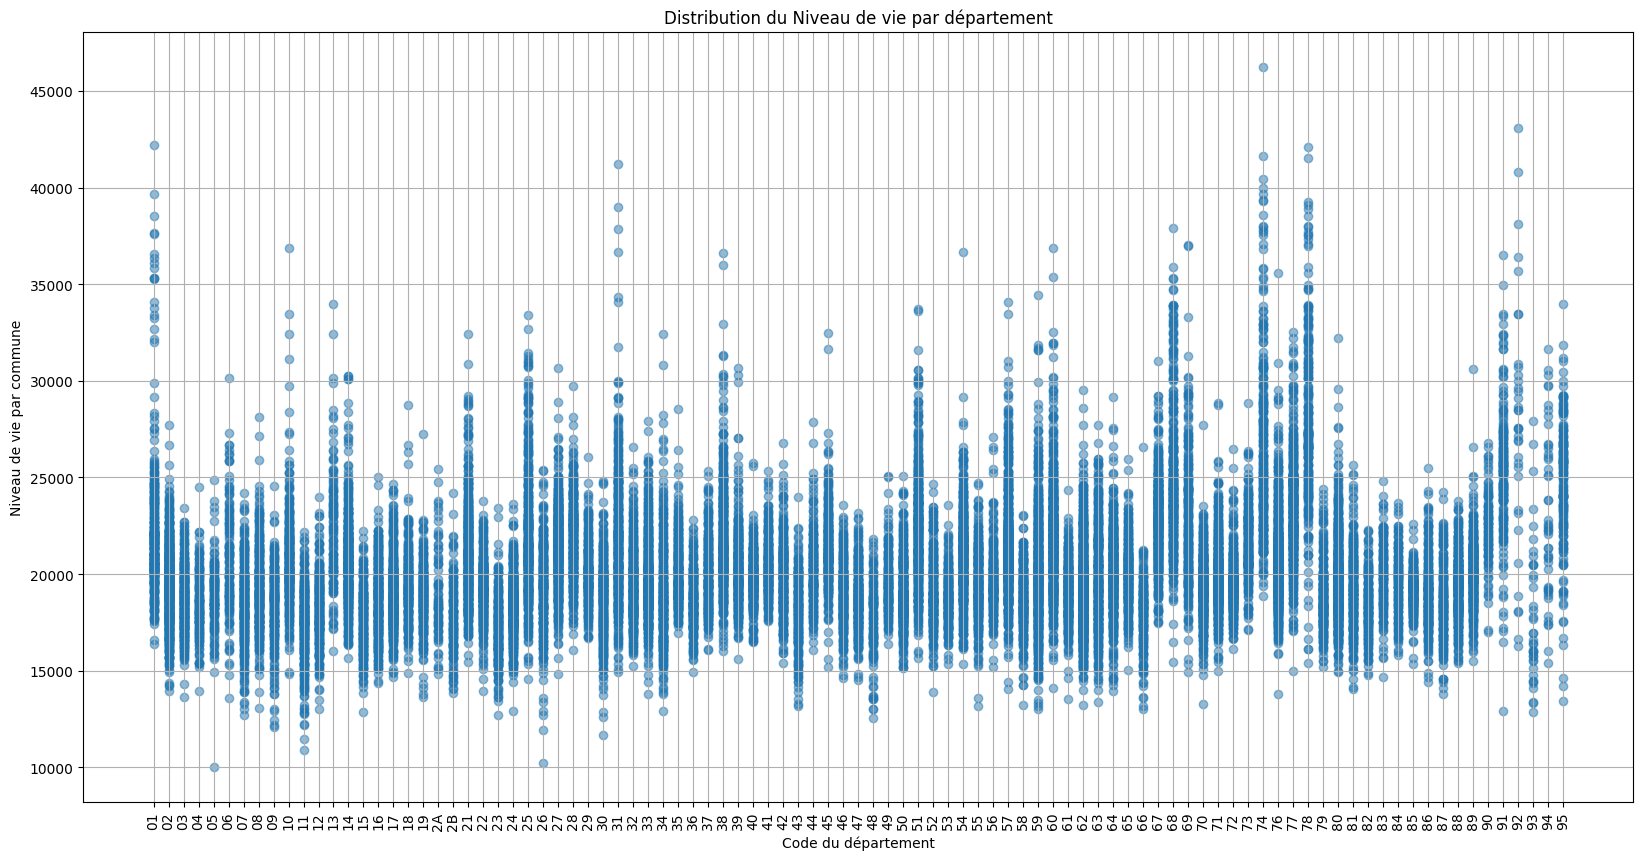

In [11]:
# plt.figure(figsize=(30, 6))  # La largeur étendue de 30 pouces est nécessaire pour rendre les codes des départements visibles sur l'axe des X.
plt.figure(figsize=(20,10)) 
plt.scatter(data['Code du département'], data['Niveau de vie Commune'], alpha=0.5)
plt.title('Distribution du Niveau de vie par département')
plt.xlabel('Code du département')
plt.ylabel('Niveau de vie par commune')
plt.grid(True)
plt.xticks(rotation=90)  
# Affichage du graphique configuré
plt.show()


### L'analyse du plot
La distribution du niveau de vie par département montre une distribution variée des niveaux de vie au sein des différents départements.
    
* **Distribution Variée :** Les points représentent le niveau de vie dans les différentes communes, répartis par code de département. La distribution semble être hétérogène avec des communes présentant des niveaux de vie aussi bien élevés que faibles au sein d'un même département.

* **Présence de variation :** Il y a des variation visibles où certaines communes ont des niveaux de vie nettement plus élevés ou plus faibles par rapport à la moyenne de leur département.

### Analyse de la Participation Électorale par Commune

L'analyse de la participation électorale est importante pour comprendre la dynamique des élections. 

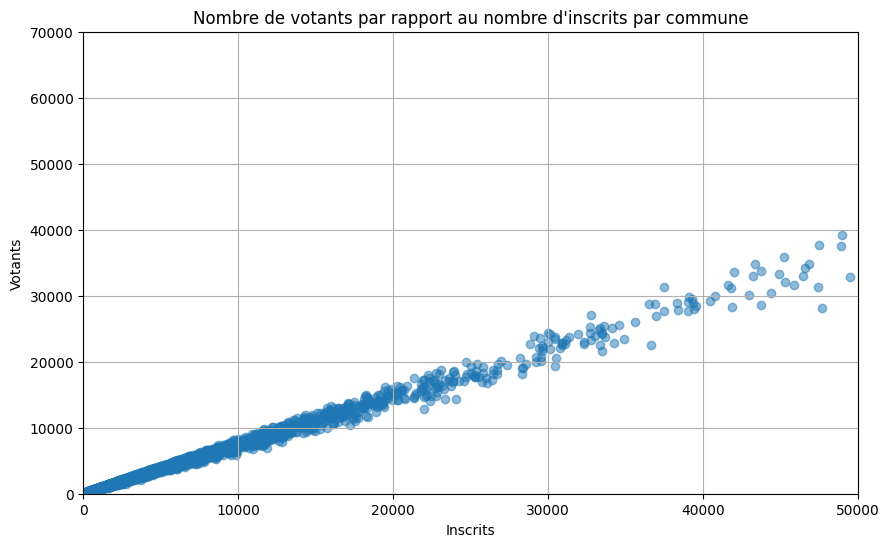

In [12]:
# Configuration de la taille de la figure graphique à 10x6 pouces
plt.figure(figsize=(10, 6))

plt.scatter(data['Inscrits'], data['Votants'], alpha=0.5)
plt.title('Nombre de votants par rapport au nombre d\'inscrits par commune')
plt.xlabel('Inscrits')
plt.ylabel('Votants')
plt.grid(True)

plt.xlim(0, 50000) # Limitation de l'axe X entre 0 et 50,000 pour améliorer la visibilité des données

# Définition des limites de l'axe des ordonnées de la même manière
plt.ylim(0, 70000) # Limitation de l'axe Y entre 0 et 70,000

# Affichage du graphique configuré
plt.show()


* La France est composée d'énormément de petites communes, nous avons donc la majorité des valeurs regroupées à un endroit avec quelques points éparses sur le reste du graphe.
* C'est un problème car ces points, certes éparses, représentent les grandes villes et donc une partie importante de nos données.
* Une représentation graphique où l'on regarde le nombre d'inscrits/de votants par commune ne semble pas être intéressant. Il serait donc préférable d'utiliser les pourcentages dans cette partie.

### Visualisation de la Corrélation entre le Niveau de Vie et l'Abstention Électorale

Pour explorer l'impact potentiel du niveau de vie sur la participation électorale. Cette analyse vise à détecter des tendances ou des corrélations qui peuvent suggérer un lien entre les conditions socio-économiques et l'engagement civique.

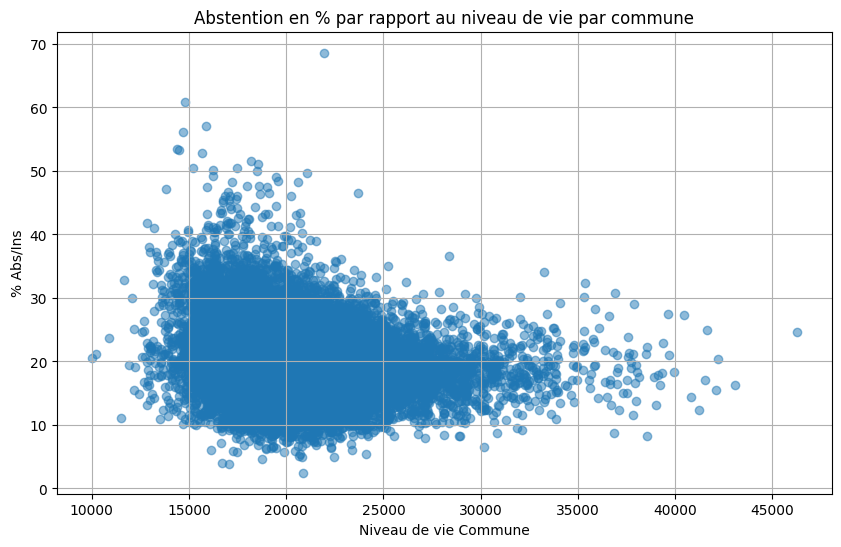

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(data['Niveau de vie Commune'], data['% Abs/Ins'], alpha=0.5)
plt.title('Abstention en % par rapport au niveau de vie par commune')
plt.xlabel('Niveau de vie Commune')
plt.ylabel('% Abs/Ins')
plt.grid(True)
plt.show()

Le niveau de vie des communes semble avoir une influence sur l'abstention mais il est difficile avec un graphe comme celui-ci d'avoir une idée précise de son impacte réel.

### Analyse du Pourcentage d'Abstention par Département

Afin de discerner des schémas d'abstention aux élections présidentielles de 2022 en France. Cette visualisation a pour but de révéler les variations de l'abstention électorale à travers les différentes régions et de souligner les spécificités départementales.

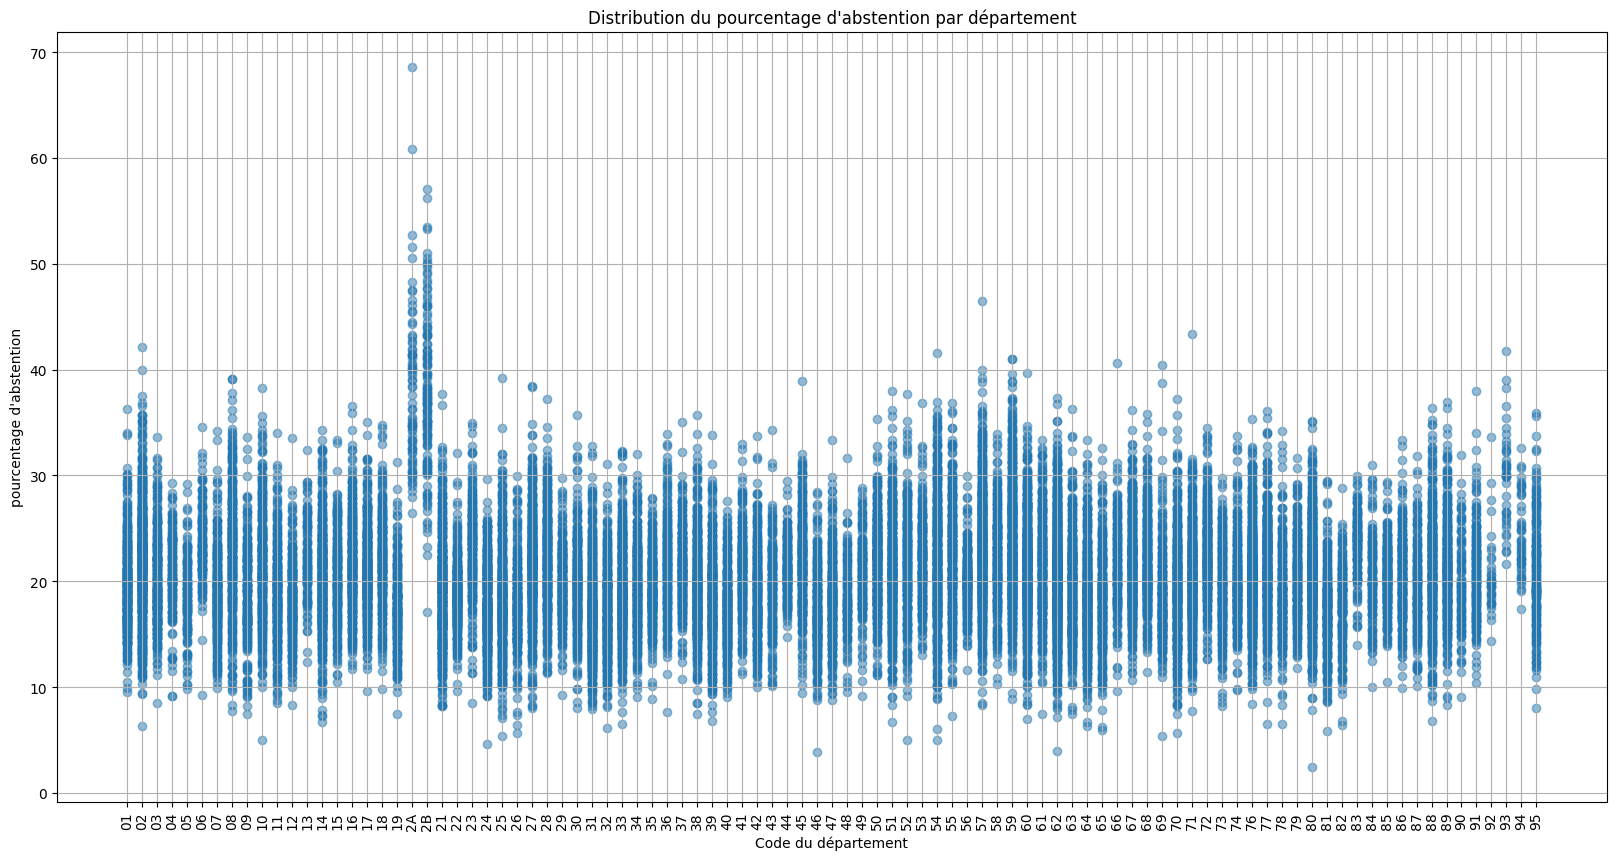

In [14]:
# plt.figure(figsize=(30, 6))  # La largeur étendue de 30 pouces est nécessaire pour rendre les codes des départements visibles sur l'axe des X.
plt.figure(figsize=(20,10))
plt.scatter(data['Code du département'], data['% Abs/Ins'], alpha=0.5)
plt.title('Distribution du pourcentage d\'abstention par département')
plt.xlabel('Code du département')
plt.ylabel('pourcentage d\'abstention')
plt.grid(True)
plt.xticks(rotation=90)  
# Affichage du graphique configuré
plt.show()


* La comparaison du pourcentage d'abstention par département semble donner des résultats bien plus intéressants que les précédents.
* On peut constater une tendance entre 10% et 40% d'abstention pour la france métropolitaine (corse exclue).\
* Il est aussi important de noter que les outre-mers et français de l'étranger ne sont pas présents sur ce graphique car éliminés par les précédents traitements. Selon nos tests cependant, nous avons constaté que ces derniers se retrouvaient avec une abstention bien plus haute que la moyenne.


* Ce graphe nous a convaincu de tenter une prédiction de l'abstention de différentes manières pour tenter de comprendre quels facteurs impactent cette statistique.

### Analyse du Pourcentage de Votes par Candidat en Fonction du Niveau de Vie

L'objectif de cette série de scatter plots est d'examiner comment le niveau de vie dans les communes a pu influencer le pourcentage de votes obtenus par chacun des candidats aux élections présidentielles. Cela nous permettra de détecter si certains candidats ont été plus populaires dans des communes avec un certain niveau de vie et d'observer des tendances qui pourraient indiquer une corrélation entre la situation économique locale et les préférences politiques.

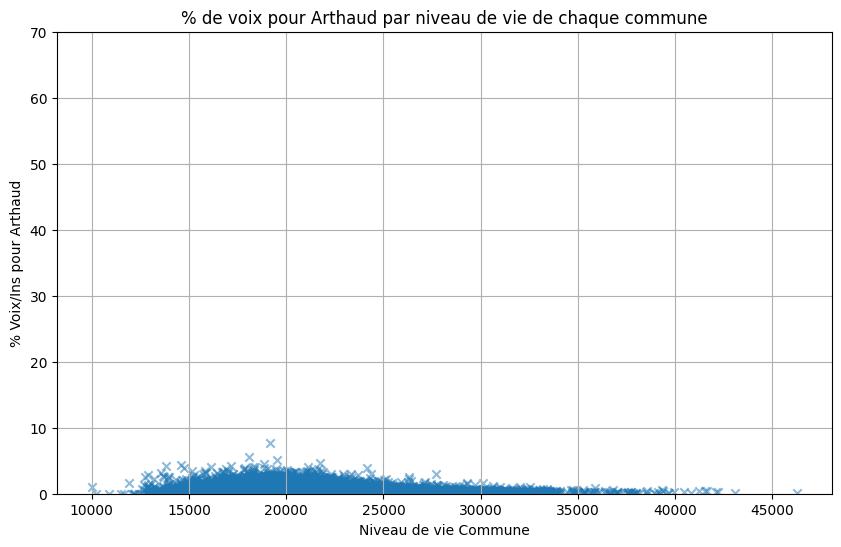

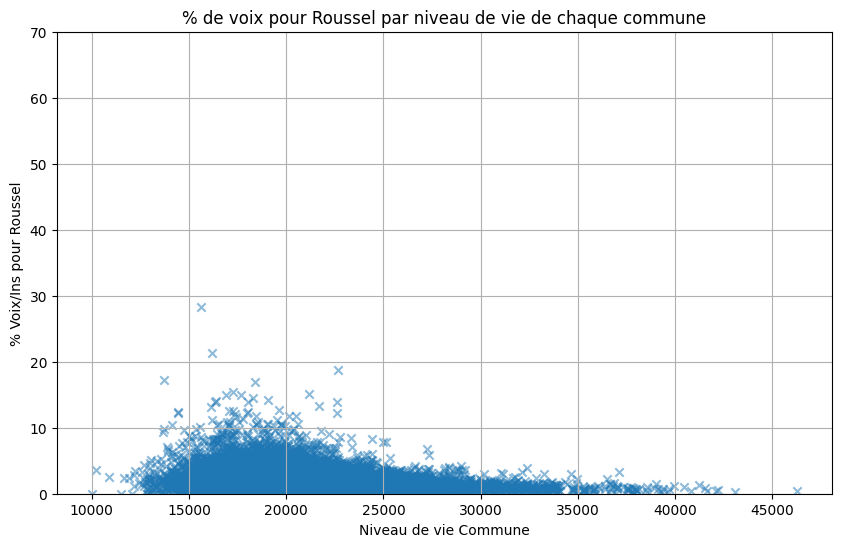

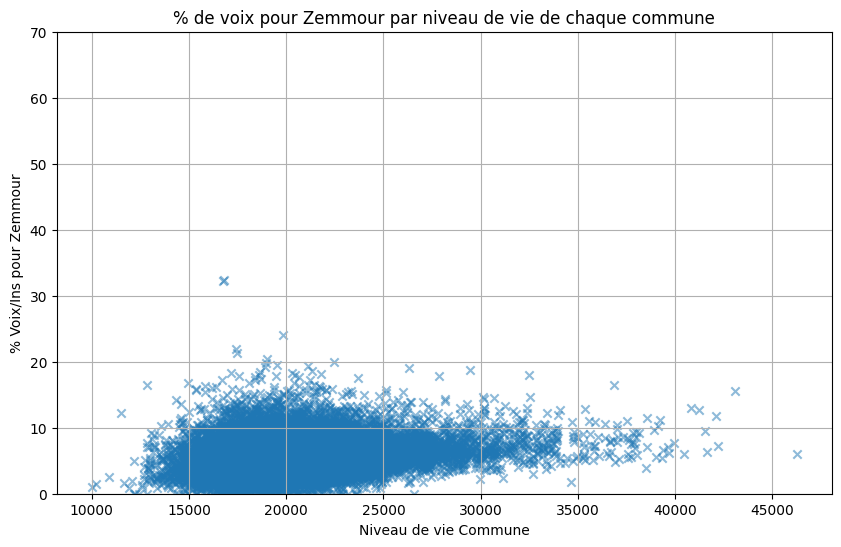

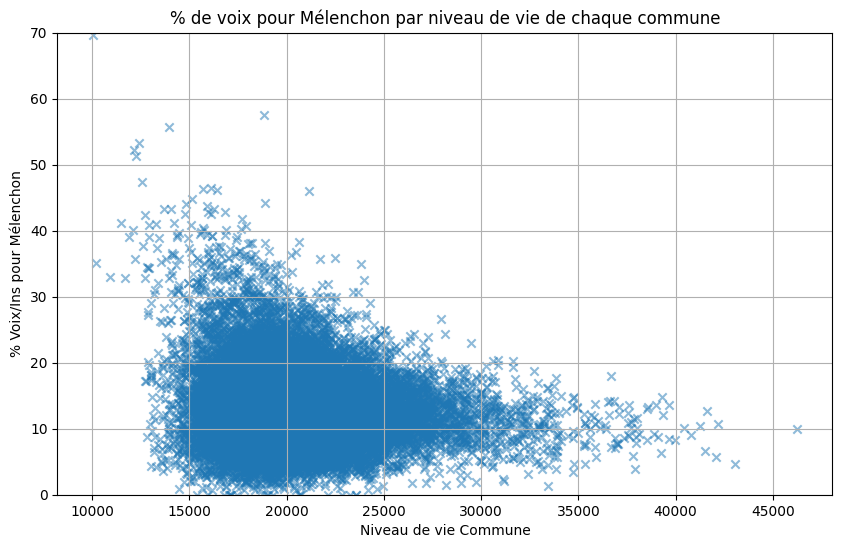

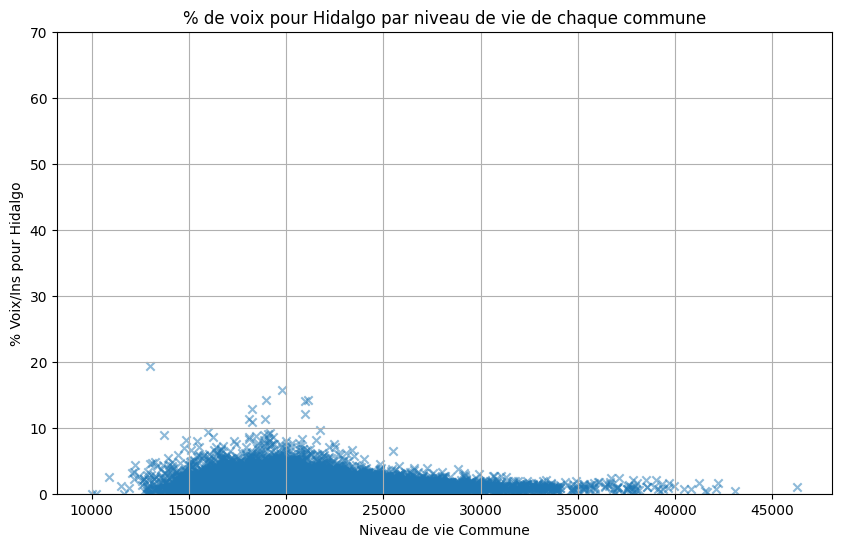

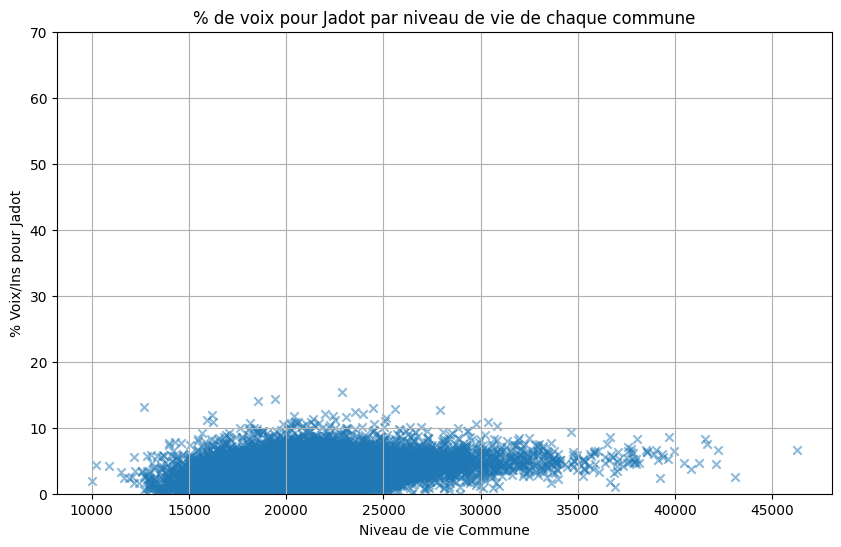

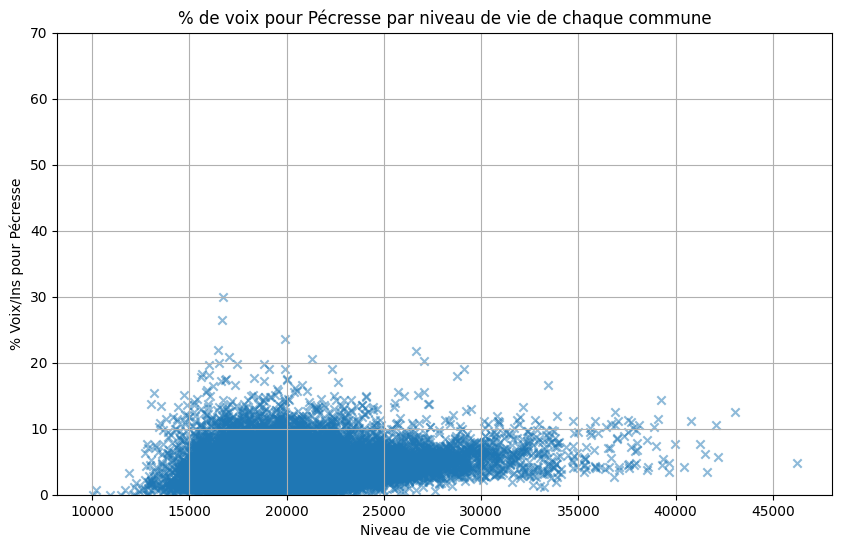

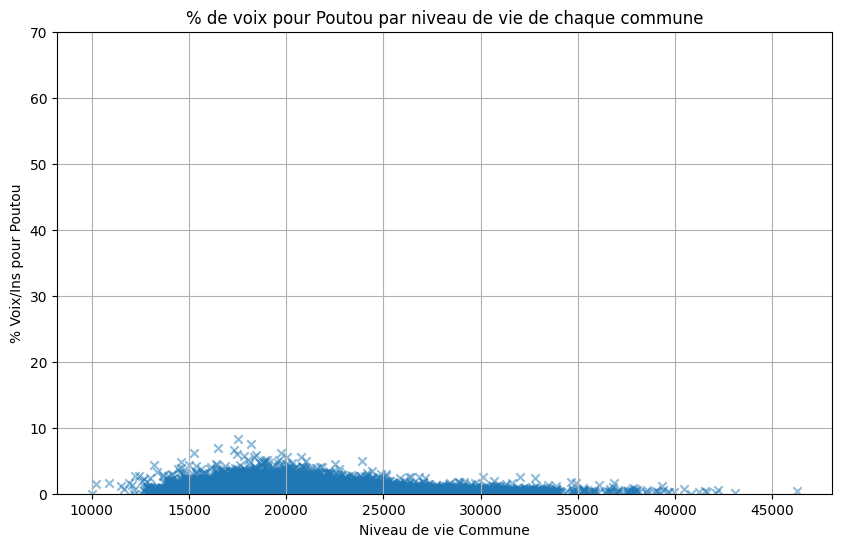

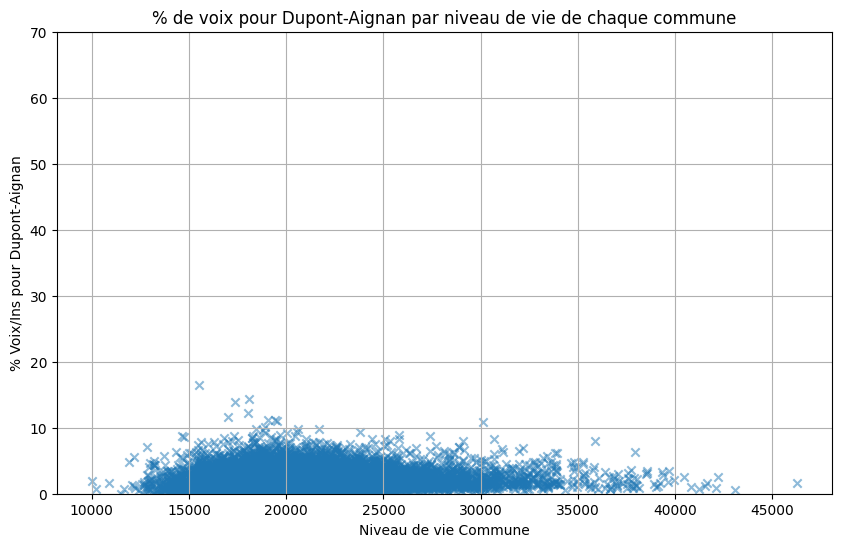

In [15]:
candidats = ['Arthaud','Roussel','Macron','Lassalle','Lepen','Zemmour','Mélenchon','Hidalgo','Jadot','Pécresse','Poutou','Dupont-Aignan']
for i in range(12):
    plt.figure(figsize=(10, 6))
    plt.ylim(0, 70)
    plt.scatter(data['Niveau de vie Commune'],
                data[f'% Voix/Ins_{i}'],
                marker='x',
                alpha=0.5)
    plt.title(f'% de voix pour {candidats[i]} par niveau de vie de chaque commune')
    plt.xlabel('Niveau de vie Commune')
    plt.ylabel(f'% Voix/Ins pour {candidats[i]}')
    plt.grid(True)
    plt.show()

* Contrairement à l'étude sur le second tour, les données ici sont plus difficiles à discerner, d'où l'importance de les afficher séparément.
* Cependant, nous pouvons constater trois candidats qui se démarquent (qui sont dans l'ordre, Macron, Lepen et Mélanchon).
* De plus, nous pouvons aussi constater la même tendance croissante sur le graphe de Macron quand le niveau de vie de la commune augmente. Tendance qui n'est visible pour aucun autre candidat.

### Hypothèses sur le Vote Présidentiel

Sur la base de cette analyse et en lien avec l'étude des tendances de vote au premier tour des élections présidentielles, voici quelques hypothèses possibles :

* **Influence Socio-Économique :**
Il est plausible que les communes avec un niveau de vie supérieur aient favorisé un candidat défendant leurs intérêts. En revanche, les communes où le niveau de vie est relativement bas auraient logiquement cherché un candidat proposant plus de changement.

* **Vote en Réponse à la Disparité Économique :**
Les disparités socio-économiques significatives au sein des départements pourraient avoir orienté le vote vers des candidats mettant en avant des programmes pour réduire les inégalités.

* **Vote et absence de vote :**
Il est possible d'avoir des résultats qui ne sont pas liés aux votes pour chaque candidat mais à l'absence de vote pour ces derniers.\
En effet, l'abstention joue un rôle important d'un point de vue politique, mais qu'en est-il du côté des statistiques ?\
Serait-il possible de pouvoir prédire une abstention à partir de différents facteurs ?

*Note : Une partie sur un réseau de neurones a été supprimée car aucun résultat n'était concluant. Nous avons préféré garder les produits finis sans les tentatives échouées.*\
*Cette partie est encore visible dans les commits du gitlab, et a été supprimée au commit "Suppression du neural network".*

# Partie 3 : Régression linéaire

### Préparation des Données pour les Analyses

In [16]:
# Conversion des codes de département à l'aide de la fonction personnalisée 'convertDepartment'.
data = convertDepartment(data)

# Conversion du type de la colonne 'Code du département' en entier.
data['Code du département'] = data['Code du département'].astype(int)

# Affichage des types de données de toutes les colonnes du DataFrame.
print(data.dtypes)


Code du département            int32
Libellé du département        object
Code de la commune             int64
Libellé de la commune         object
Etat saisie                   object
                              ...   
Voix_11                        int64
% Voix/Ins_11                float64
% Voix/Exp_11                float64
Niveau de vie Commune        float64
Niveau de vie Département    float64
Length: 105, dtype: object


Code pour identifier le top 3 des candidats ayant reçu le plus de votes pour le choix des features.

In [17]:
colonne_max_occurrences = []

# Création d'une liste des noms de colonnes pour lesquelles vérifier le maximum
liste = [f"Voix_{i}" for i in range(12)] 

# Boucle sur chaque ligne du DataFrame pour déterminer quelle colonne a la valeur maximale
for i in range(len(data)):
    # Extraction des valeurs de chaque colonne spécifiée pour la ligne courante
    values = [data[colonne][i] for colonne in liste]
    # Ajout de l'indice de la colonne avec la valeur maximale dans la liste
    colonne_max_occurrences.append(np.argmax(values))

# Calcul des valeurs uniques et de leurs fréquences dans la liste des indices maximaux
valeurs_uniques, occurrences = np.unique(colonne_max_occurrences, return_counts=True)

# Tri des indices de ces occurrences pour les ordonner par fréquence décroissante
sorted_indices = np.argsort(occurrences)[::-1]
# Application des indices triés pour ordonner les valeurs uniques et les occurrences
sorted_valeurs_uniques = np.array(valeurs_uniques)[sorted_indices]
sorted_occurrences = np.array(occurrences)[sorted_indices]

# Sélection des trois indices les plus fréquents
top_3 = sorted_valeurs_uniques[:3]
# Affichage des trois premiers indices
print(top_3)


[4 2 6]


In [18]:
# Création d'un nouveau DataFrame 'X' à partir de colonnes spécifiques du DataFrame original 'data'.
# Ce nouveau DataFrame inclut les informations démographiques et de vote essentielles.
X = data[['Code du département', 'Code de la commune', 'Inscrits', 'Niveau de vie Commune', 'Niveau de vie Département']].copy()

# Boucle pour ajouter à 'X' les colonnes correspondant aux votes du top 3 des candidats.
for valeur in top_3:
    colonne_voix = f'Voix_{valeur}'
    X[colonne_voix] = data[colonne_voix].copy()

# Définition des variables cibles 'y1' et 'y2' pour les modèles de prédiction ou analyses statistiques.
y1 = data['% Abs/Ins']
y2 = data['Abstentions']


### Modélisation de la Régression Linéaire avec OLS pour Sélection de Caractéristiques

Dans notre analyse de l'impact des variables socio-économiques sur l'abstention électorale, nous utilisons la méthode des moindres carrés ordinaires (OLS) pour construire des modèles de régression linéaire. Le but principal de ces modèles est de sélectionner les meilleures caractéristiques (features) qui influencent le plus l'abstention, en utilisant deux variables dépendantes différentes pour comprendre divers aspects de l'abstention électorale. Les statistiques détaillées fournies par chaque modèle nous aideront à évaluer la validité et l'efficacité des caractéristiques sélectionnées.

In [19]:
# Créer le modèle OLS
m = OLS(y1, X)
results1 = m.fit()
su1 = results1.summary()
su1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              % Abs/Ins   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.948
Method:                 Least Squares   F-statistic:                          7.143e+04
Date:                Mon, 22 Apr 2024   Prob (F-statistic):                        0.00
Time:                        22:22:57   Log-Likelihood:                         -93740.
No. Observations:               31368   AIC:                                  1.875e+05
Df Residuals:                   31360   BIC:                                  1.876e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Code du département           0.0195      0.001     18.111      0.000       0.017       0.022
Code de la commune            0.0020      0.000     13.120      0.000       0.002       0.002
Inscrits                      0.0012      0.000     10.738      0.000       0.001       0.001
Niveau de vie Commune        -0.0005   1.15e-05    -40.618      0.000      -0.000      -0.000
Niveau de vie Département     0.0014   1.18e-05    119.399      0.000       0.001       0.001
Voix_4                        0.0010      0.000      4.148      0.000       0.001       0.002
Voix_2                       -0.0037      0.000    -16.656      0.000      -0.004      -0.003
Voix_6                       -0.0017      0.000     -9.119      0.000      -0.002      -0.001
==============================================================================
Omnibus:                     4321.388   Durbin-Watson:                   1.403
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41082.999
Skew:                           0.346   Prob(JB):                         0.00
Kurtosis:                       8.564   Cond. No.                     1.13e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interprétation des Résultats de la Régression OLS pour le Pourcentage d'Abstention par Inscrits

Les résultats de notre régression linéaire visant à comprendre l'influence des variables socio-économiques sur le pourcentage d'abstention par rapport aux inscrits (`% Abs/Ins`) montrent que le modèle a un très haut niveau de précision, avec un $R^2$ = 0.948. Cela suggère que notre modèle explique 94.8% de la variance du pourcentage d'abstention, ce qui est remarquable pour des analyses basées sur de vraies données démographiques et socio-économiques.

#### Statistiques du Modèle:

- **$R^2$ :** 0.948 - Indique que presque 95% de la variabilité dans le pourcentage d'abstention par rapport aux inscrits est expliquée par le modèle, un indicateur de la très forte capacité prédictive du modèle.

- **Valeurs p:**
  - Tous les coefficients présentent des valeurs p de 0.000, affirmant leur significativité statistique. Cela valide l'influence forte et non due au hasard de ces variables sur le pourcentage d'abstention.

In [20]:
n = OLS(y2, X)
results2 = n.fit()
su2 = results2.summary()
su2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Abstentions   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          4.705e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):                        0.00
Time:                        22:22:57   Log-Likelihood:                     -1.9563e+05
No. Observations:               31368   AIC:                                  3.913e+05
Df Residuals:                   31360   BIC:                                  3.913e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Code du département           0.3042      0.028     10.962      0.000       0.250       0.359
Code de la commune            0.0474      0.004     12.286      0.000       0.040       0.055
Inscrits                      0.6781      0.003    244.287      0.000       0.673       0.684
Niveau de vie Commune        -0.0039      0.000    -13.113      0.000      -0.004      -0.003
Niveau de vie Département     0.0016      0.000      5.128      0.000       0.001       0.002
Voix_4                       -0.5924      0.006    -91.600      0.000      -0.605      -0.580
Voix_2                       -1.1229      0.006   -196.518      0.000      -1.134      -1.112
Voix_6                       -0.5537      0.005   -112.230      0.000      -0.563      -0.544
==============================================================================
Omnibus:                    30144.731   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1005538553.253
Skew:                          -2.911   Prob(JB):                         0.00
Kurtosis:                     880.106   Cond. No.                     1.13e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interprétation des Résultats de la Régression OLS pour les Abstentions

Les résultats de la régression linéaire effectuée pour comprendre les facteurs influençant les abstentions montrent des statistiques très significatives avec un $R^2$ = 0.992. Cela indique que notre modèle explique presque parfaitement la variabilité des abstentions à partir des variables sélectionnées. Les détails des résultats et l'interprétation des coefficients sont les suivants:

#### Statistiques du Modèle:

- **$R^2$ :** 0.992 - Le modèle capture 99.2% de la variance des abstentions, ce qui est exceptionnellement élevé pour des données réelles, suggérant une très forte prédiction des niveaux d'abstention par les variables incluses.

#### Valeurs p et Signification Statistique:
Tous les coefficients présentent des valeurs p de 0.000, ce qui les rend statistiquement significatifs. Cela confirme la forte influence de ces variables sur le modèle et valide leur pertinence dans la prédiction des abstentions.


## Analyse des Résidus de la Régression Linéaire

Après avoir ajusté notre modèle de régression linéaire OLS, il faut examiner les résidus pour vérifier l'adéquation du modèle. 
#### Objectifs de l'Analyse des Résidus

- **Identifier des Tendances**: Les résidus devraient être distribués de manière aléatoire sans aucun motif apparent. La présence de tendances ou de modèles peut indiquer des problèmes tels que la non-linéarité dans la relation entre les variables ou des erreurs de spécification du modèle.

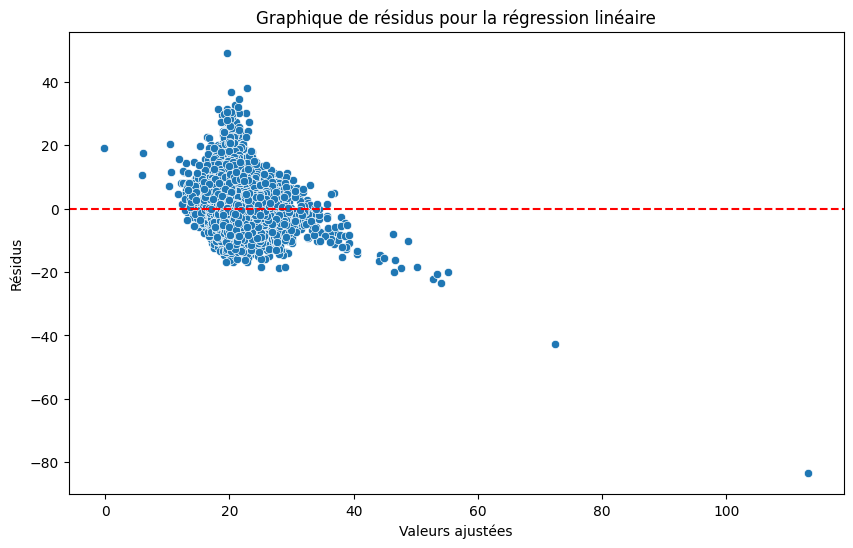

In [21]:
residus = results1.resid

plt.figure(figsize=(10, 6))
sns.scatterplot(x=results1.fittedvalues, y=residus)
plt.title('Graphique de résidus pour la régression linéaire')
plt.xlabel('Valeurs ajustées')
plt.ylabel('Résidus')
plt.axhline(y=0, color='red', linestyle='--')  # Ligne horizontale pour résidus = 0
plt.show()


D'après le graphique, il semble que :

* **Distribution des Résidus :** Les résidus ne montrent pas de motif clair et sont dispersés autour de la ligne zéro, ce qui est bon signe car cela indique que le modèle ne souffre pas de non-linéarité.
* **Variance des Résidus :** Il y a une concentration de résidus autour de la plage inférieure des valeurs ajustées, et à mesure que les valeurs ajustées augmentent, l'étalement des résidus augmente également.

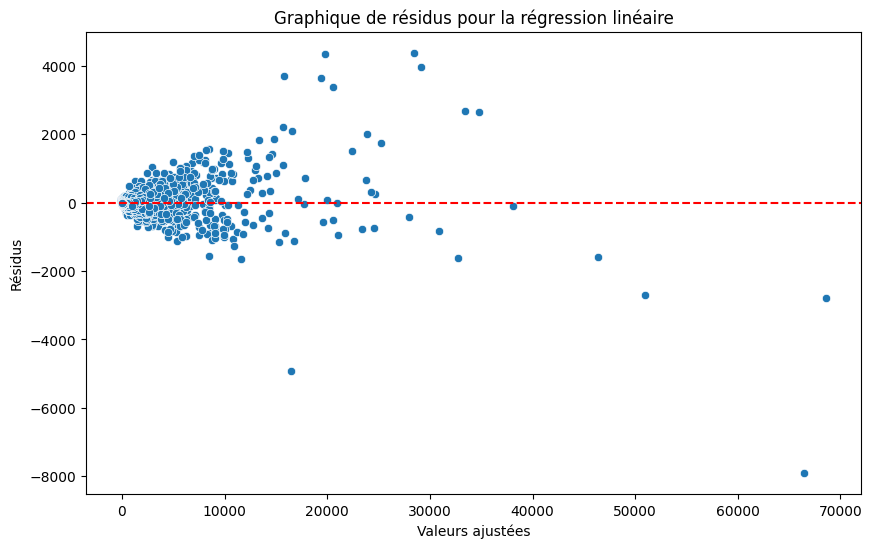

In [22]:
residus = results2.resid

plt.figure(figsize=(10, 6))
sns.scatterplot(x=results2.fittedvalues, y=residus)
plt.title('Graphique de résidus pour la régression linéaire')
plt.xlabel('Valeurs ajustées')
plt.ylabel('Résidus')
plt.axhline(y=0, color='red', linestyle='--')  # Ligne horizontale pour résidus = 0
plt.show()


D'après le graphique, il semble que :
* **Concentration des Résidus :** La majorité des résidus se regroupent près de la ligne zéro, ce qui indique l'absence de biais systématique dans les prédictions du modèle.

### Construction et Évaluation du Modèle de Régression Linéaire

In [23]:
# Création d'une instance du modèle de régression linéaire.
model = lm.LinearRegression()

# Entraînement du modèle de régression linéaire avec les données contenues dans 'X' et la variable cible 'y1'.
model.fit(X, y1)

# Impression du score R² du modèle, qui mesure la qualité de l'ajustement du modèle sur les données.
print("Score = ", model.score(X, y1))

print(model.coef_)

# La prédiction du modèle pour la valeur de base des inputs.
print(model.intercept_)


Score =  0.14119856104683381
[ 0.02219125  0.00115206  0.00092392 -0.00044345  0.0002178   0.00100973
 -0.00256124 -0.00157783]
23.378586694590798


### Résultats de la Régression Linéaire

- **Score $R^2$ :** Le score $R^2$ du modèle est de 0.1412, ce qui signifie que le modèle explique environ 14.12% de la variabilité du pourcentage d'abstention. Nous pouvons donc en conclure qu'une régression linéaire n'est pas adaptée pour prédire un pourcentage d'abstention.

- **Interception :** L'ordonnée à l'origine (environ 23.38) représente le pourcentage d'abstention estimé quand toutes les variables explicatives sont évaluées à zéro.


In [24]:
model = lm.LinearRegression()
model.fit(X, y2)

print(model.score(X,y2))
print(model.coef_)
print(model.intercept_)

0.9912354826089528
[ 3.07945396e-01  4.62222232e-02  6.77779908e-01 -3.84012000e-03
 -1.28920447e-04 -5.92490564e-01 -1.12134130e+00 -5.53429355e-01]
33.07792376096171


### Évaluation de Performance du Modèle de Régression Linéaire

#### Interprétation des Résultats:

- **Score R² :** Le score R² est  élevé, à 0.9912, indiquant que le modèle explique près de 99.12% de la variabilité des abstentions. Cela révèle une corrélation forte entre les variables sélectionnées et les abstentions enregistrées.
- **Interception :** L'intercept du modèle est de 33.0779, ce qui peut être interprété comme le nombre d'abstentions prévu lorsque toutes les variables explicatives sont à zéro, bien que cette situation soit improbable dans la pratique.

### Conclusion Générale des Modèles de Régression linéaire

* Les analyses effectuées à l'aide de deux modèles de régression linéaire ont produit des résultats contrastés.

* Ces résultats soulignent la complexité de la modélisation du comportement électoral. Alors que certains facteurs sont des indicateurs solides du nombre total d'abstentions, ils sont moins prédictifs lorsqu'il s'agit de déterminer le taux d'abstention proportionnellement au nombre d'inscrits. Cela pourrait refléter la nature multifactorielle et nuancée de la participation électorale, soulignant le besoin de modèles plus sophistiqués ou de la collecte de données supplémentaires pour une image plus complète.

# Partie 4 : Régression logistique

### Identification du Candidat le Plus Voté par Commune

In [25]:
# Initialisation de la liste qui va contenir les indices des candidats avec le maximum de voix pour chaque ligne
y_classification = []

# Création d'une liste de noms de colonnes pour les voix des différents candidats
liste = [f"Voix_{i}" for i in range(12)]

# Itération sur chaque ligne du DataFrame pour déterminer quel candidat a le plus de voix
for i in range(len(data)):
    # Extraction des valeurs des voix pour tous les candidats de la ligne courante
    values = [data[colonne][i] for colonne in liste]
    # Identification de l'indice de la colonne qui contient la valeur maximale (le plus de voix)
    max_index = np.argmax(values)
    # Récupération du numéro du panneau correspondant à ce candidat et ajout à la liste y_classification
    y_classification.append(data[f'N°Panneau_{max_index}'][i])

# Conversion de la liste en un tableau numpy pour une manipulation plus facile et performante dans des analyses ultérieures
y_classification = np.array(y_classification)


### Préparation des Données pour l'Analyse de Classification

In [26]:
# Préparation du DataFrame 'X_classification' qui contiendra les variables explicatives pour une analyse de classification.
X_classification = data[['Code du département', 'Code de la commune', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', 
                         '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins', '% Nuls/Vot', 
                         'Exprimés', '% Exp/Ins', '% Exp/Vot', 'Niveau de vie Commune', 'Niveau de vie Département']].copy()


print(X_classification.shape)
print(y_classification.shape)
print(X_classification.head())
print(X_classification.dtypes)

(31368, 18)
(31368,)
   Code du département  Code de la commune  Inscrits  Abstentions  % Abs/Ins  \
0                    1                   1       645          108      16.74   
1                    1                   2       213           38      17.84   
2                    1                   4      8765         2078      23.71   
3                    1                   5      1282          234      18.25   
4                    1                   6       103           23      22.33   

   Votants  % Vot/Ins  Blancs  % Blancs/Ins  % Blancs/Vot  Nuls  % Nuls/Ins  \
0      537      83.26      16          2.48          2.98     1        0.16   
1      175      82.16       3          1.41          1.71     1        0.47   
2     6687      76.29      88          1.00          1.32    46        0.52   
3     1048      81.75      14          1.09          1.34     6        0.47   
4       80      77.67       3          2.91          3.75     0        0.00   

   % Nuls/Vot  Exprimés

### Visualisation de la Distribution des Candidats les Plus Votés par Commune

Après avoir déterminé le candidat le plus voté dans chaque commune, il est utile de visualiser la distribution de ces candidats à travers l'ensemble des communes.

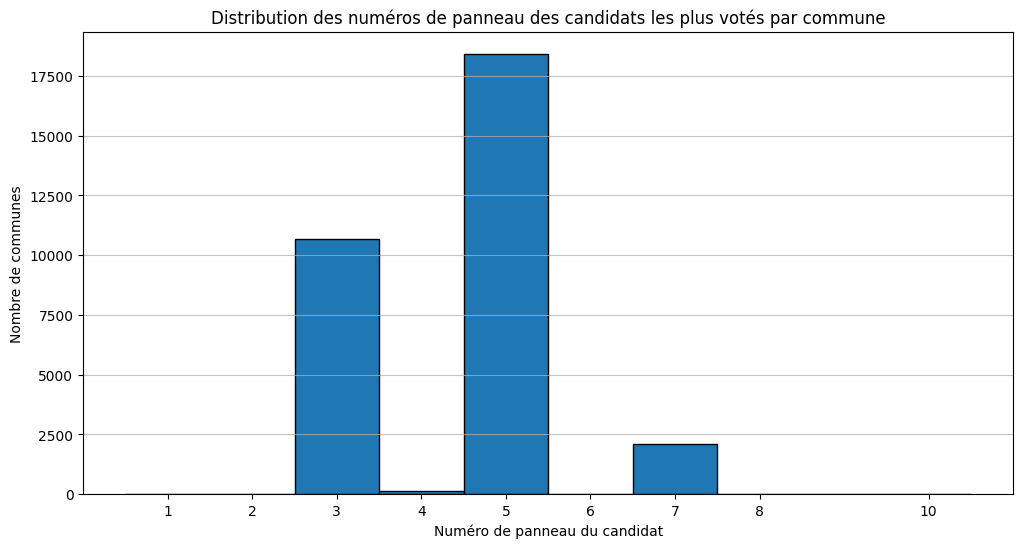

[0, 12, 8, 31992, 584, 92030, 60, 14805, 8, 0, 100, 0]


In [27]:
# Conversion de la liste en un tableau numpy pour une manipulation plus facile
y_classification = np.array(y_classification)

# Création de l'histogramme
plt.figure(figsize=(12, 6))
plt.hist(y_classification, bins=np.arange(y_classification.min(), y_classification.max()+2) - 0.5, edgecolor='black')
plt.xticks(np.unique(y_classification))
plt.title('Distribution des numéros de panneau des candidats les plus votés par commune')
plt.xlabel('Numéro de panneau du candidat')
plt.ylabel('Nombre de communes')
plt.grid(axis='y', alpha=0.75)

# Affichage du graphique
plt.show()
print([np.sum(y_classification,where=y_classification==i) for i in range(12)])

Dans l'ordre : (Arthaud), Roussel, Macron, Lassalle, Lepen, Zemmour, Mélenchon, Hidalgo, Jadot, Pécresse, Poutou, Dupont-Aignan

* L'histogramme montre la distribution des numéros de panneau des candidats qui ont reçu le plus grand nombre de voix par commune. On observe que certains numéros de panneau se distinguent nettement, indiquant que dans un grand nombre de communes, ces candidats spécifiques ont été les plus votés.
* le candidat associé au numéro de panneau 5 (Lepen) semble avoir été le plus voté dans une proportion significative de communes, suivi par celui avec le numéro de panneau 3 (Macron).

* On peut constater que Macron est arrivé en tête dans moins de communes que Lepen, cependant il est important de noter que Macron a obtenu 27.8% des voix lors de ce premier tour contre 23.1% pour Lepen.
Cela montre l'importance de ce schémat. Il montre que Lepen a plus souvent gagné dans les petites communes, tandis que Macron a gagné dans les grandes villes. Cela explique notamment le schémat des votes par candidat vu dans la partie 2.

### Affinement des Caractéristiques et Modélisation OLS pour la Classification

Pour affiner notre modèle et potentiellement améliorer sa performance, nous allons exclure certaines caractéristiques qui pourraient être redondantes ou moins pertinentes pour la prédiction du candidat le plus voté dans chaque commune. Ensuite, nous appliquerons une régression OLS à notre ensemble de données modifié pour observer l'influence des caractéristiques restantes sur la classification des résultats des votes.

In [28]:
features_to_exclude = ['Votants', 'Exprimés']

X_classification = X_classification.drop(columns=features_to_exclude)
# Créer le modèle OLS
m = OLS(y_classification, X_classification)
results = m.fit()
su = results.summary()
su

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                          3.302e+04
Date:                Mon, 22 Apr 2024   Prob (F-statistic):                        0.00
Time:                        22:22:58   Log-Likelihood:                         -47170.
No. Observations:               31368   AIC:                                  9.437e+04
Df Residuals:                   31352   BIC:                                  9.451e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Code du département          -0.0007      0.000     -2.648      0.008      -0.001      -0.000
Code de la commune            0.0002   3.42e-05      4.808      0.000    9.74e-05       0.000
Inscrits                  -3.987e-05   1.15e-05     -3.474      0.001   -6.24e-05   -1.74e-05
Abstentions                   0.0004   3.14e-05     11.980      0.000       0.000       0.000
% Abs/Ins                    -0.9072      1.359     -0.668      0.504      -3.570       1.756
% Vot/Ins                     1.0029      1.758      0.571      0.568      -2.442       4.448
Blancs                       -0.0054      0.001    -10.328      0.000      -0.006      -0.004
% Blancs/Ins                 -1.8730      1.101     -1.701      0.089      -4.031       0.285
% Blancs/Vot                  0.9274      1.359      0.682      0.495      -1.736       3.591
Nuls                         -0.0022      0.001     -4.338      0.000      -0.003      -0.001
% Nuls/Ins                   -1.9358      1.100     -1.760      0.078      -4.091       0.219
% Nuls/Vot                    0.9696      1.359      0.714      0.475      -1.694       3.633
% Exp/Ins                    -1.9178      1.099     -1.745      0.081      -4.072       0.236
% Exp/Vot                     0.9824      1.359      0.723      0.470      -1.681       3.645
Niveau de vie Commune        -0.0001   2.65e-06    -45.959      0.000      -0.000      -0.000
Niveau de vie Département  4.149e-06   5.39e-06      0.770      0.441   -6.41e-06    1.47e-05
==============================================================================
Omnibus:                      106.470   Durbin-Watson:                   1.693
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.224
Skew:                           0.136   Prob(JB):                     3.16e-24
Kurtosis:                       3.096   Cond. No.                     1.45e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.45e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Analyse de la Signification Statistique des Variables du Modèle OLS

* Comme pour le second tour, on élimine les lignes dont le P > |t| est supérieur à 0.05, ce qui représente les valeurs qui ne sont pas pertinentes.

#### Variables Candidats pour l'Exclusion :

- **Variables avec p > 0,05** : 
  - `% Abs/Ins` (p = 0,504) et `% Vot/Ins` (p = 0,568),
  - De même, `% Blancs/Vot` (p = 0,495), `% Nuls/Vot` (p = 0,475) et `% Exp/Vot` (p = 0,470),
  - `% Blancs/Ins` (p = 0,089), `% Nuls/Ins` (p = 0,078) et `% Exp/Ins` (p = 0,081),
  - `Niveau de vie Département` (p = 0,441).

In [29]:
features_to_exclude = ['% Abs/Ins','% Vot/Ins','% Blancs/Ins','% Blancs/Vot','% Nuls/Ins','% Nuls/Vot','% Exp/Ins','% Exp/Vot','Niveau de vie Département']

X_classification = X_classification.drop(columns=features_to_exclude)
# Créer le modèle OLS
m = OLS(y_classification, X_classification)
results = m.fit()
su = results.summary()
su
# A supprimer si ça va pas

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.901
Model:                            OLS   Adj. R-squared (uncentered):              0.901
Method:                 Least Squares   F-statistic:                          4.085e+04
Date:                Mon, 22 Apr 2024   Prob (F-statistic):                        0.00
Time:                        22:22:58   Log-Likelihood:                         -56075.
No. Observations:               31368   AIC:                                  1.122e+05
Df Residuals:                   31361   BIC:                                  1.122e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Code du département       0.0027      0.000      8.320      0.000       0.002       0.003
Code de la commune        0.0007   4.51e-05     14.580      0.000       0.001       0.001
Inscrits                 -0.0003   1.42e-05    -20.502      0.000      -0.000      -0.000
Abstentions               0.0013   3.99e-05     32.480      0.000       0.001       0.001
Blancs                   -0.0056      0.001     -8.473      0.000      -0.007      -0.004
Nuls                      0.0006      0.001      1.135      0.257      -0.000       0.002
Niveau de vie Commune     0.0002   1.01e-06    199.693      0.000       0.000       0.000
==============================================================================
Omnibus:                      628.462   Durbin-Watson:                   1.545
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1077.377
Skew:                          -0.174   Prob(JB):                    1.12e-234
Kurtosis:                       3.839   Cond. No.                     1.77e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Variables Candidats pour l'Exclusion :

- **Variables avec p > 0,05** : 
  - `Nuls` (p = 0,257).

In [30]:
features_to_exclude = ['Nuls']

X_classification = X_classification.drop(columns=features_to_exclude)
# Créer le modèle OLS
m = OLS(y_classification, X_classification)
results = m.fit()
su = results.summary()
su
# A supprimer si ça va pas

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.901
Model:                            OLS   Adj. R-squared (uncentered):              0.901
Method:                 Least Squares   F-statistic:                          4.766e+04
Date:                Mon, 22 Apr 2024   Prob (F-statistic):                        0.00
Time:                        22:22:58   Log-Likelihood:                         -56076.
No. Observations:               31368   AIC:                                  1.122e+05
Df Residuals:                   31362   BIC:                                  1.122e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Code du département       0.0027      0.000      8.338      0.000       0.002       0.003
Code de la commune        0.0007   4.51e-05     14.585      0.000       0.001       0.001
Inscrits                 -0.0003   1.31e-05    -21.789      0.000      -0.000      -0.000
Abstentions               0.0013   3.96e-05     32.569      0.000       0.001       0.001
Blancs                   -0.0058      0.001     -9.229      0.000      -0.007      -0.005
Niveau de vie Commune     0.0002   1.01e-06    199.785      0.000       0.000       0.000
==============================================================================
Omnibus:                      658.042   Durbin-Watson:                   1.545
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1170.955
Skew:                          -0.170   Prob(JB):                    5.38e-255
Kurtosis:                       3.884   Cond. No.                     1.58e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Analyse de Significativité des Prédicteurs du Modèle OLS

Les statistiques obtenues de notre régression linéaire OLS suggèrent une forte capacité du modèle à expliquer la variable dépendante `y`, avec un $R^2$ non centré de 0.901. Ce niveau élevé indique une forte corrélation entre les prédicteurs sélectionnés et la variable cible.

#### Statistiques du Modèle :

- **$R^2$ non centré :** 0.901 - Cela implique que le modèle explique 90.1% de la variance observée, une indication d'une forte relation globale entre les variables indépendantes et la variable dépendante.

### Ajustement du Modèle de Régression Logistique

Nous allons maintenant entraîner un modèle de régression logistique pour classer les communes selon le candidat le plus voté. La régression logistique est particulièrement adaptée pour les problèmes de classification et permet de traiter les cas où la variable dépendante est catégorique.

In [31]:
lr_model = LogisticRegression(solver='newton-cholesky',max_iter=1000)

# Train the model
lr_model.fit(X_classification, y_classification)

print(f"Model weights (theta_1, theta_2): {lr_model.coef_}, bias (theta_0): {lr_model.intercept_}")
print(f"r^2: {lr_model.score(X_classification, y_classification)}")

Model weights (theta_1, theta_2): [[ 9.88021983e-03  5.80324938e-04  1.18737774e-03  7.02469137e-03
  -2.14757259e+00 -1.73359342e-05]
 [ 2.98310540e-02 -6.05456286e-03 -1.60860484e-03  8.81560241e-03
  -2.87994701e-01 -7.84170889e-04]
 [-1.37396917e-03 -7.56887145e-04  4.27666743e-04 -2.18778162e-03
   2.05528482e-02  2.37145282e-04]
 [ 2.74918179e-02 -4.98260847e-04 -6.06301270e-03  1.27566127e-02
  -3.71281609e-02 -3.39190477e-04]
 [ 3.00872557e-03  1.01677106e-03 -3.28255797e-04  1.32737900e-03
  -1.70015409e-02 -1.55219787e-04]
 [ 2.34296085e-02 -6.08228595e-03 -7.20572027e-04 -2.02410871e-02
   1.01644207e-01 -3.23856808e-04]
 [-7.73024494e-03 -1.43576481e-03 -3.69984864e-05  3.52349138e-04
  -1.21932393e-03 -2.72789283e-04]
 [-6.32416768e-02 -5.95794926e-02 -1.53402296e-01  9.71983152e-02
  -1.12625819e+00 -1.32630433e-03]
 [ 2.61189881e-02 -2.65871901e-03 -1.14626895e-02  2.31900540e-02
   1.60424640e-01 -3.65023969e-04]], bias (theta_0): [-6.45989822  5.35695541 -5.47069285  1

### Analyse des Résultats du Modèle de Régression Logistique

Une fois le modèle de régression logistique entraîné, nous avons obtenu des coefficients pour chacune des variables explicatives ainsi que l'intercept du modèle. Ces coefficients, ou poids, nous indiquent la force et la direction de la relation entre chaque variable indépendante et la probabilité pour un électeur de voter pour le candidat le plus voté dans chaque commune.

#### Performance du Modèle :

- Le **score $R^2$**  en régression logistique ne représente pas la proportion de variance expliquée par le modèle. Il est plutôt une mesure de la précision de classification.

- Avec un $R^2$ = 0.66, nous pouvons constater que la régression logistique est performante sur ce dataset avec une précision comparable à celle du second tour.

### Conclusion Générale par Rapport aux Hypothèses Initiales

Nos analyses statistiques, à travers la régression linéaire et logistique, ont permis d'évaluer les hypothèses concernant les tendances de vote au premier tour des élections présidentielles.

#### Influence Socio-Économique :
Les modèles ont mis en évidence une relation significative entre le niveau de vie et le comportement de vote. Le niveau de vie des communes a montré une influence notable sur les taux d'abstention, corroborant l'hypothèse que les communes plus aisées auraient tendance à voter différemment de celles avec un niveau de vie inférieur. Les variables socio-économiques étaient statistiquement significatives, suggérant que des intérêts économiques peuvent effectivement influencer le choix des électeurs.

#### Vote en Réponse à la Disparité Économique :
Les résultats de la régression indiquent que les disparités économiques ont eu un impact sur le vote. Cependant, la relation n'était pas uniforme et variait selon la mesure de l'abstention utilisée, indiquant que la réponse au niveau de disparité peut être plus nuancée que prévu. Les variables telles que le pourcentage de votes blancs et nuls n'ont pas toujours été significatives, ce qui peut suggérer que d'autres facteurs non économiques jouent un rôle dans la décision de s'abstenir ou de voter blanc ou nul.

#### Vote et Absence de Vote :
Les analyses ont confirmé que l'abstention peut être prédite par divers facteurs. Les modèles ont fourni une compréhension de la relation entre l'abstention et des facteurs tels que la taille de la population électorale et le niveau de vie. Cela valide l'idée que l'abstention est un phénomène complexe qui peut être influencé par une combinaison de variables démographiques et économiques.

### Réflexions Finales :
Bien que nos modèles aient capturé une part significative de la variabilité dans les données de vote, il est clair que la réalité du comportement électoral est multifactorielle et que d'autres variables, au-delà de celles incluses dans nos modèles, affectent la décision de voter pour un candidat, de s'abstenir, ou de voter blanc ou nul. Il est probable que des facteurs tels que les enjeux politiques spécifiques, les campagnes électorales, les événements d'actualité et les dynamiques de groupe jouent également un rôle crucial dans le comportement de vote.

Il serait donc impossible de prédire une future élection si celle-ci est trop éloignée en terme de temps. Cependant, ces données ont été intéressantes à analyser pour comprendre plutôt que prédire, afin d'expliquer pourquoi certains résultats ont eu lieu. Le tout, sans sortir des chiffres.